## Load and process audio

Пробовала использовать библиотеки: **pytube** (удобный питоновский интерфейс) и **youtube-dl**. Однако из-за того, что они давно не обновлялись, YT поменял какие-то правила создания автоматических субтитров, эти библиотеки перестали парсить субтитры --> я использовала более поздний форк youtube-dl -- **yt-dlp** (поддерживает расширенный функционал и исправляет баги). Я извлекла видео и субтиртры, потом с помощью других инструментов и библиотек привела аудио к .wav формату, стандартной частоте дискретизации 16000Гц и 1 каналу (stereo --> mono, это оказалось важным, так как в SpeechRecognition они делают самостоятельно, но при запуске других библиотек "из коробки" распознавание будет очень плохим, если этого не сделать. Сначала это было не очень очевидно☺️)

In [ ]:
!pip install yt-dlp webvtt-py pydub

In [ ]:
!pip install git+https://github.com/openai/whisper.git soundfile

In [ ]:
!yt-dlp -x --audio-format "wav" --write-auto-subs  "https://www.youtube.com/watch?v=bEKufM_im88&ab_channel=Vogue"

In [ ]:
import webvtt

def get_text_for_timespan(srt_file, start_time, end_time):
    subtitles = webvtt.read(srt_file)

    target_text = ""
    for subtitle in subtitles:
        subtitle_start = subtitle.start_in_seconds
        subtitle_end = subtitle.end_in_seconds

#         print(subtitle_end)
        # Check if the subtitle timespan overlaps with the target timespan
        if subtitle_end - subtitle_start > 2:
            if subtitle_end > start_time and subtitle_start < end_time:
                target_text += subtitle.text.strip() + ' '

    return target_text.strip()

# Example usage
srt_file_path = 'Kylie Jenner\'s New Classic Beauty Routine ｜ Beauty Secrets ｜ Vogue [bEKufM_im88].en.vtt'
start_time = 177  # start time in seconds
end_time = 277    # end time in seconds

result_text = get_text_for_timespan(srt_file_path, start_time, end_time)

if result_text:
    print(f"Text for timespan {start_time} to {end_time} seconds: {result_text}")

    with open('yt-auto.txt', 'w') as f:
        f.write(result_text)
else:
    print("No matching subtitles found for the specified timespan.")


Важный момент про автоматические субтитры: YT странно их генерирует -- получается очень много повторов:  
<center>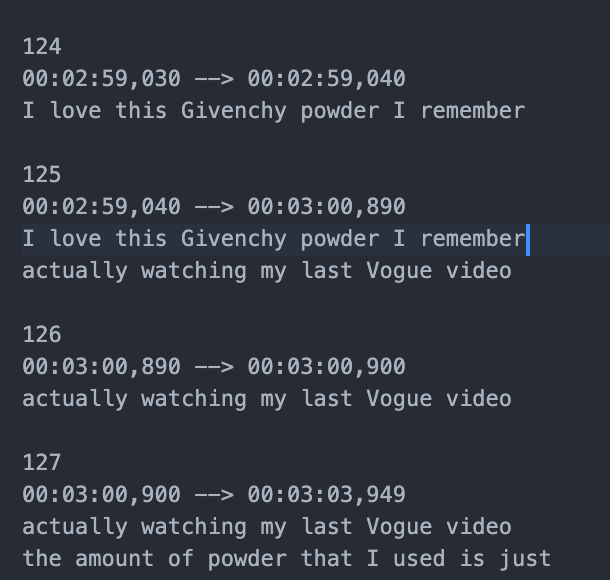</center>

Чтобы избавиться от большинства из них при переводе из .vtt в .txt выбирала только такие реплики, длина которых больше 2 секунд.



In [ ]:
from pydub import AudioSegment

def audio_cutter(start, end, path):
    sound = AudioSegment.from_file(path)

    ready = sound[start*1000:end*1000]
    ready.export('cut_to_10_sent.wav')

audio_cutter(177, 277, 'Kylie Jenner\'s New Classic Beauty Routine ｜ Beauty Secrets ｜ Vogue [bEKufM_im88].wav')

In [ ]:
!ffmpeg -y -i cut_to_10_sent.wav -acodec pcm_s16le -ar 16000 -ac 1 cut_to_10_sent_new.wav

## Systems and libraries

Системы: Whisper, Wav2Vec, Vosk  
Библиотеки: SpeechRecognition, transformers(HF), vosk

В таблице с результатми название систем:{система}-{библиотека}

In [ ]:
!pip install SpeechRecognition transformers vosk

In [ ]:
!wget https://alphacephei.com/vosk/models/vosk-model-small-en-us-0.15.zip
!unzip vosk-model-small-en-us-0.15.zip
!mv vosk-model-small-en-us-0.15 model

In [ ]:
!wget https://alphacephei.com/vosk/models/vosk-model-en-us-0.22.zip
!unzip vosk-model-en-us-0.22.zip
!mv vosk-model-en-us-0.22 model_base

In [ ]:
import speech_recognition as sr
import pandas as pd
import os
from vosk import Model, KaldiRecognizer
import wave
from transformers import pipeline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def sr_prep(filename):
    file = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = file.record(source)

    return file, audio

def get_asr(filename, system, model_size='base'):
    if system == 'whisper':
        file, audio_data = sr_prep(filename)
        text = file.recognize_whisper(audio_data=audio_data, model=model_size)
    elif system == 'vosk':
        file, audio_data = sr_prep(filename)
        text = eval(file.recognize_vosk(audio_data))
    elif system == 'wav2vec':
        transcriber = pipeline("automatic-speech-recognition", "facebook/wav2vec2-base-960h", device='cuda')
        text = transcriber(filename, chunk_length_s=15)

    elif system == 'whisper-hf':
        transcriber = pipeline(
            task="automatic-speech-recognition",
            model="openai/whisper-large",
            device='cuda')
        text = transcriber(filename, chunk_length_s=15)

    elif system == 'vosk+kaldi':
        model_size = 'base'
        model = Model('./model_base')

        recognizer = KaldiRecognizer(model, 16000)
        chunk_size = 1024  # Adjust the chunk size as needed
        with wave.open(filename, 'rb') as audio_file:
            sample_rate = audio_file.getframerate()
            while True:
                audio_data = audio_file.readframes(chunk_size)
                if not audio_data:
                    break
                recognizer.AcceptWaveform(audio_data)
        text = eval(recognizer.FinalResult())

    with open(f'{system}_{model_size}_recs.txt', 'w') as f:
        if isinstance(text, dict):
            f.write(text['text'].lower())

        else:
            f.write(text.lower())

    if isinstance(text, dict):
        return text['text'].lower()

    else:
        return text.lower()



In [ ]:
systems_asr = ['whisper', 'vosk', 'wav2vec', 'whisper-hf', 'vosk+kaldi']
texts = {}
for i in systems_asr:
    print(i)
    texts[i] = get_asr('cut_to_10_sent_new.wav', i)


whisper
vosk


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from model/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from model/graph/HCLr.fst model/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo model/graph/phones/word_boundary.int


wav2vec


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
whisper-hf


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


vosk+kaldi


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:11:12:13:14:15
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from ./model_base/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from ./model_base/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from ./model_base/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo ./model_base/graph/phones/word_boundary.int
LOG (VoskAPI:ReadDataFiles():model.cc:315) Loading subtract G.fst model from ./model_base/rescor

In [ ]:
!pip install jiwer

In [ ]:
df = pd.DataFrame.from_dict(texts, orient='index', columns = ['recognized']).rename_axis('system').reset_index()

In [ ]:
import re
from jiwer import wer
gold_path = '/kaggle/input/new-gold/gold.txt'
def wer_err(recognized, path):
    recognized = re.sub(r'[\.,]', '', recognized)
    with open(path) as file:
        gold = file.read()
    gold = re.sub(r'[\.,]', '', gold)
    return wer(gold, recognized)

In [ ]:
pd.set_option('display.max_colwidth', 1000)

In [ ]:
df['wer'] = df.apply(lambda x: wer_err(x['recognized'], gold_path), axis=1)
df['system'] = ['whisper-sr', 'vosk-sr', 'wav2vec-hf', 'whisper-hf', 'vosk-api', 'yt-auto']
df.sort_values(by=['wer'])

,system,recognized,wer
3,whisper-hf,"givenchy powder. i remember actually watching my last vogue video. the amount of powder that i used is just unreal. so i'm gonna do a little bit of powder on here. stormy still doesn't really play with makeup. i love these charlotte tilbury powders. i think that when we're looking for inspo for events and makeup looks, we get inspiration from everywhere like old fashion shows, i'm always on pinterest, and just getting inspiration and how we can make it our own and modern and like a very experimental era with makeup and i'm so willing to try new things and new looks. another secret, i have these amazing sets of these cream shadows that are here. you could put this directly on your eye. i'm going for a lighter look, so i'm gonna put it on the palette. a little goes a long way, and they don't dry too fast. so i like that you can play with them for a little. i like to focus on the outer corner of the eye, but also like, i love a dragged out shadow look. this is just a really pretty ne...",0.012987
0,whisper-sr,"this g1 sheet powder. i remember actually watching my last vogue video. the amount of powder that i used is just unreal. i'm going to do a little bit of powder on here. store me. still, it doesn't really play with makeup. i love these charlatte tilbury powders. i think that when we're looking for info for events and makeup looks, we get inspiration from everywhere like old fashion shows, always on pinterest, and just getting inspiration and how we can make it our own and modern and like a very experimental era with makeup. and i'm so willing to try new things and new looks, another secret. i have these amazing sets of these cream shadows to start here. you could put this directly on your eye. i'm going for a lighter look, so i'm going to put it on the palette. the little goes a long way, and they don't dry too fast, so i like that you can play with them for a little. i like to focus on the outer corner of the eye, but also i kind of love a dragged out shadow look. this is just a r...",0.099567
4,vosk-api,was she when she powder i remember actually watching my last spoke video now the powder they used is just unreal i'm gonna do a little bit of powder on here for me still doesn't really play with makeup i love the charlotte tilbury powders i think that when we're looking for inspo for events and makeup looks we get inspiration from everywhere like old fashion shows moyes on pinterest and just getting inspiration and then how we can make it our own and modern and like a very experimental era with makeup and i'm so willing to try new things and new looks another secret i have these amazing sex cookies cream shadows start here you can put this directly on your eye i'm going for a lighter looks i'm gonna put it on a panel at the little goes a long way and they don't try too fast so they can play with them for a little and i'm too focused on the outer corner of the eye but also like love and dragged out shadow look this is just a really pretty neutral matte palette for everyday people wh...,0.216450
1,vosk-sr,soon as she powder armor actually watching my last spoke video him out of powder that i used is just unreal similar do little bit of powder on here stormy still doesn't early to make up and love these charlotte tilbury powders i think that when we're looking for and so for events and make a blocks to get it's version from everywhere like old fashion shows movies on interest and just getting inspiration and how we can make it our own in modern and like a very experimental era with make up and i'm so willing to try new things a new looks and other secret i have use mean same sas to these cream shadows star here you can put the strictly on your i'm going for a lighter looks more put it on a pow a little goes a long way and spin entre too fast so think they can play with them for little lm to focused on the outer corners i but also like love and dragged out shadow look this is just a really p

In [ ]:
df.sort_values(by=['wer']).to_csv('results.csv')

## Эталон
В качестве эталона я опиралась на результат whisper-hf (там используется их large модель) -- практически все было распознано правильно -- пропущено было только слово this в начале. Приятно удивило, что все имена собственные были правильно распознаны.  
## Улучшения
В качестве улучшений предлагаю исползовать модели бОльшего размера. Конечно, это дороже с точки зрения ресурсов, но hugging face, например, дает возможность переноса на гпу и предлагает деление аудиозаписи на чанки (а-ля батчи), чем я и воспользовалась. Если загружать модель в память только один раз и использовать одну модель (ситуация инференса), то по сильного удара по ресурсам не будет. Whisper-hf (whisper-large) дает идеальный результат, в то время как whisper-sr (whisper-base) уже путается с именами собственными и разворачивает вещи типа *i'm gonna do* в *i'm going to do*, что не всегда желательно. Large модель также дает лучшее качество и в системе Vosk.

## Overall
1. **На мой взгляд HF+whisper -- лучший вариант**:  
    a. whisper (особенно large) обучен на очень большом корпусе (уверена, что туда входили YT видео, поэтому модель так хорошо отлавливает сленг, например, *inspo* (из *inspiration*)), в особенности сконцентрированном на англйиском --> он аутперформит большинство ASR моделей и показывает SoTA результаты  
    б. HF дает больше возможностей -- перенос на гпу, авто-деление на чанки. У SR я таких фичей не нашла (Vosk-API также не поддерживает работу на гпу 😭)
2. Если смотреть глазами, то **автоматические субтитры ютуба не так уж плохи**, если как-то избавиться от повторений (я немного почистила повторы), то результат будет лучше.